In [1]:
!pip install catboost
!pip install ngboost

     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 349 kB 7.6 MB/s 
     |████████████████████████████████| 68 kB 2.4 MB/s 
     |████████████████████████████████| 38.1 MB 90.9 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=4023e303b735a2e7fa2164f3be401bf8874236b7d480c2371e124694e1651c08
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# 라이브러리 Import
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings


from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.utils import shuffle
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from ngboost import NGBRegressor


In [4]:
data_train = pd.read_csv('/content/gdrive/MyDrive/데이콘_소비자데이터기반_소비예측/train.csv')
data_test = pd.read_csv('/content/gdrive/MyDrive/데이콘_소비자데이터기반_소비예측/test.csv')
submission = pd.read_csv('/content/gdrive/MyDrive/데이콘_소비자데이터기반_소비예측/sample_submission.csv')

In [8]:
print(data_train.shape)
data_train.head(3).transpose()

(1108, 22)


,0,1,2
id,0,1,2
Year_Birth,1974,1962,1951
Education,Master,Graduation,Graduation
Marital_Status,Together,Single,Married
Income,46014.0,76624.0,75903.0
Kidhome,1,0,0
Teenhome,1,1,1
Dt_Customer,21-01-2013,24-05-2014,08-04-2013
Recency,21,68,50
NumDealsPurchases,10,1,2


In [9]:
print(data_test.shape)
data_test.head(3).transpose()

(1108, 21)


,0,1,2
id,0,1,2
Year_Birth,1979,1955,1984
Education,Graduation,Graduation,Graduation
Marital_Status,Single,Together,Married
Income,57537.0,65748.0,55434.0
Kidhome,1,0,1
Teenhome,0,1,0
Dt_Customer,10-06-2013,15-04-2013,05-10-2013
Recency,83,58,21
NumDealsPurchases,4,2,3


In [7]:
submission.head(3)

,id,target
0,0,0
1,1,0
2,2,0


### Feature 설명
- id : 샘플 아이디
- Year_Birth : 고객 생년원일
- Education : 고객 학력
- Marital_status : 고객 결혼 상태
- Income : 고객 연간 가구 소득
- Kidhome : 고객 가구의 자녀 수
- Teenhome : 고객 가구의 청소년 수
- Dt_Customer : 고객이 회사에 등록한 날짜
- Recency : 고객의 마지막 구매 이후 일수
- NumDealsPurchases : 할인된 구매 횟수
- NumWebPurchases : 회사 웹사이트를 통한 구매 건수
- NumCatalogPurchases: 카탈로그를 사용한 구매 수
- NumStorePuchases : 매장에서 직접 구매한 횟수
- NumWebVisitsMonth : 지난 달 회사 웹사이트 방문 횟수
- AcceptedCmp1: 고객이 첫 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp2: 고객이 두 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp3: 고객이 세 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp4: 고객이 네 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp5: 고객이 5번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- Complain : 고객이 지난 2년 동안 불만을 제기한 경우 1, 그렇지 않은 경우 0
- Response : 고객이 마지막 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- target : 고객의 제품 총 소비량

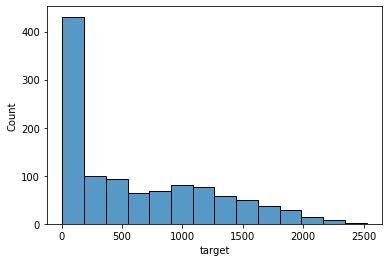

In [10]:
sns.histplot(data_train['target'])

In [12]:
# Range라는 새로운 feature 만들기 
data_train_T = data_train['target']
target = []
for i in range(len(data_train_T)):
  if data_train_T.iloc[i]<250:
    target.append(1)
  elif data_train_T.iloc[i] < 1000:
    target.append(2)
  elif data_train_T.iloc[i] < 1800:
    target.append(3)
  else:
    target.append(4)

data_train["Range"] = target

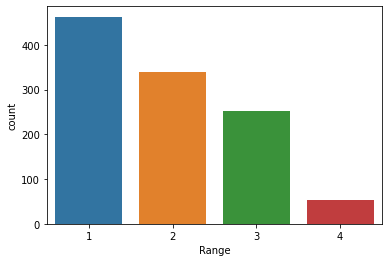

In [13]:
sns.countplot(x = data_train['Range'])

target의 분포가 0~250 사이의 데이터가 많고, 2000 이후의 샘플에 대한 데이터가 충분하지 않아 ,high target에 대해서 잘 맞추지 못한다.

# 데이터 전처리
- 데이터 전처리
- 새로운 feature 생성

In [21]:
# object 형태의 데이터를 학습 가능한 형태로 변경시켜줘야 한다.
# Education, Marital_Status, Dt_Customer
data_train.dtypes

id                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Response                 int64
target                   int64
Range                    int64
dtype: object

### 문자 자료형 Education, Marital_Status 숫자로 인코딩 하기

In [14]:
data_train['Education']

0           Master
1       Graduation
2       Graduation
3            Basic
4              PhD
           ...    
1103    Graduation
1104    Graduation
1105        Master
1106    Graduation
1107           PhD
Name: Education, Length: 1108, dtype: object

In [15]:
data_train['Education'].value_counts()

Graduation    570
PhD           254
Master        173
2n Cycle       89
Basic          22
Name: Education, dtype: int64

## Education - label encoding 사용
- Basic, Graduation, 2n_cycle, Master, phD
- 0, 1, 2, 3, 4

In [23]:
# train set 및 test set에 적용
for data in [data_train, data_test]:
  for i in range(len(data_train)):
    education = data['Education'].iloc[i]
    if education in ["Basic"]:
      data['Education'].iloc[i]=0
    elif education in ['Graduation']:
      data['Education'].iloc[i] =1
    elif education in ['2n_cycle']:
      data['Education'].iloc[i] = 2
    elif education in ['Master']:
      data['Education'].iloc[i] = 3
    else:
      data['Education'].iloc[i]=4

## one hot encoding 사용하여 결혼 / 싱글 두가지로 인코딩
- 결혼, 동거 = 0, Married, Together
- 싱글 = Single, Divorced, Widow, Alone, YOLO, Absurd

In [24]:
# train set 및 test set에 적용
for data in [data_train, data_test]:
  for i in range(data.shape[0]):
    marital_status = data['Marital_Status'].iloc[i]
    if marital_status in ['Married', 'Together']:
      data['Marital_Status'].iloc[i] = 0
    else:
      data['Marital_Status'].iloc[i] = 1

### 타임스탬프 Dt_Customer를 회사 가입 개월수인 Sign_Month로 변환
- sign_month = 사이트에 가입하고 몇개월이나 지났는가? 높을수록 예전에 가입한사람

In [25]:
for data in [data_train, data_test]:
    for i in range(data.shape[0]):
        data['Dt_Customer'].iloc[i] = int(data['Dt_Customer'].iloc[i][-1]) * 12 + int(data['Dt_Customer'].iloc[i][3:5])
        
recent_month = max(data_train['Dt_Customer'])

for data in [data_train, data_test]:
    month_arr = []
    for i in range(data.shape[0]):
        month_arr.append(recent_month - data['Dt_Customer'].iloc[i])
        
    data['Sign_Month'] = month_arr

## 새로운 Feature 만들기

### AcceptedCmp(1~5)와 Response 변수로 새 Feature 생성
- 위 여섯개의 변수는 고객이 1~5번째와 마지막 캠페인에서 제안을 수락한 경우 1, 아닌 경우 0값을 가진다.
- 모두 더해서 하나의 변수로 만들어주기

In [26]:
data_train['total_Accept'] = data_train['AcceptedCmp1'] + data_train['AcceptedCmp2'] +data_train['AcceptedCmp3'] +data_train['AcceptedCmp4'] + data_train['AcceptedCmp5'] +data_train['Response'] 
data_test['total_Accept'] = data_test['AcceptedCmp1'] + data_test['AcceptedCmp2'] +data_test['AcceptedCmp3'] +data_test['AcceptedCmp4'] + data_test['AcceptedCmp5'] +data_test['Response'] 

### Year_Birth를 이용해 나이 Age Feature 만들기

In [ ]:
data_train['Age'] = 2022 - data_train['Year_Birth']
data_test['Age'] = 2022 - data_test['Year_Birth']

### Dependents = Kidhome + Teenhome
- Kidhome : 고객 가구의 자녀 수
- Teenhome : 고객 가구의 청소년 수
- 중첩되는 부분이 있을 수 있지만 모델의 성능에는 도움을 줄 수 있을 것 같다.

In [27]:
data_train['Dependents'] = data_train['Kidhome'] + data_train['Teenhome']
data_test['Dependents'] = data_test['Kidhome'] + data_test['Teenhome']

## 필요 없는 Feature 삭제

In [ ]:
data_train = data_train.drop(['id','Dt_Customer', 'Year_Birth','Education','Marital_Status'], axis=1)
data_test = data_test.drop(['id','Dt_Customer', 'Year_Birth','Education','Marital_Status'], axis=1)

# 모델 생성 및 학습하기
- stratified k-fold 사용
- LGBM, XGB, Catboost
- Voting 사용

In [30]:
data_train_X = data_train.drop(["target"], axis = 1)
data_train_y = data_train["target"]

In [31]:
def NMAE(true, pred):
    score = np.mean(np.abs(true - pred) / true)
    return score

In [32]:
# overfitting을 방지하기 위해 skf 진행
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True) #총 10번의 fold 진행
n = 0 #x번째 fold인지 기록

fold_target_pred = []
fold_score = []


# 앞에서 만든 range 기준으로 stratified k fold 진행
for train_index, valid_index in skf.split(data_train_X, data_train_X['Range']): 
    n += 1
    
    val_pred_name = [] #validation pred model 이름 저장
    val_pred = []      #validation set pred 결과 저장
    target_pred = []   #test set pred 결과 저장
    
    #분배된 학습을 위해 생성한 Range feature 제거
    train_X = np.array(data_train_X.drop("Range", axis = 1)) 
    train_Y = np.array(data_train_y)
    
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    y_train, y_valid = train_Y[train_index], train_Y[valid_index]
    
    X_test = np.array(data_test)

    ### Create Model ###
    
    ###모델을 생성하고 집어넣으면 됩니다.
    
    ### LGBMRegressor ###
    model = LGBMRegressor(random_state = 42, verbose = 0) 
    model.fit(X_train, y_train) # 모델 학습
    
    val_pred_name.append("LGBMRegressor")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### XGBRegressor ###
    model = XGBRegressor(random_state = 42) 
    model.fit(X_train, y_train)
    
    val_pred_name.append("XGBRegressor")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### CatBoostRegressor ###
    model = CatBoostRegressor(random_state = 42) 
    model.fit(X_train, y_train)
    
    val_pred_name.append("CatBoostRegressor")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### voting ###
    
    ### average validation pred ###
    preds = np.array(val_pred[0])
    for i in range(1, len(val_pred)):
        preds += val_pred[i] # validation predict 값을 다 합친 것
    
    preds = preds/len(val_pred) # validation predict 평균
    
    ### average target pred ###
    target_preds = np.array(target_pred[0])
    for i in range(1, len(target_pred)):
        target_preds += target_pred[i] # data_test predict를 모두 더한 값.
    
    target_preds = target_preds/len(target_pred) # data_test predict 평균
    
    fold_target_pred.append(target_preds) # append final target pred
    
    print("========== fold %d ==========" %(n))
    for i in range(len(val_pred)):
        print("%s model NMAE : %0.4f" %(val_pred_name[i], NMAE(y_valid, val_pred[i].astype(int))))
        
    print("==============================")
    print("Average NMAE %0.4f" %(NMAE(y_valid, preds.astype(int))))
    print("")
    
    fold_score.append(NMAE(y_valid, preds.astype(int)))

total_score = fold_score[0]
for i in range(2, len(fold_score), 1):
    total_score += fold_score[i]
total_score = total_score/(len(fold_score))    

print("==============================")
print("Total Average NMAE %0.4f" %(total_score)) #최종 average score 출력

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
45:	learn: 236.9551631	total: 66ms	remaining: 1.37s
46:	learn: 234.5417292	total: 67.3ms	remaining: 1.36s
47:	learn: 232.0369170	total: 68.6ms	remaining: 1.36s
48:	learn: 229.6558728	total: 69.9ms	remaining: 1.36s
49:	learn: 227.3776830	total: 71.3ms	remaining: 1.35s
50:	learn: 225.2774498	total: 72.4ms	remaining: 1.35s
51:	learn: 223.4581163	total: 73.6ms	remaining: 1.34s
52:	learn: 221.8393035	total: 74.9ms	remaining: 1.34s
53:	learn: 219.9287695	total: 76.2ms	remaining: 1.33s
54:	learn: 218.2494383	total: 77.2ms	remaining: 1.33s
55:	learn: 216.6778980	total: 78.5ms	remaining: 1.32s
56:	learn: 215.3096562	total: 81.4ms	remaining: 1.35s
57:	learn: 213.6642664	total: 82.7ms	remaining: 1.34s
58:	learn: 212.3906980	total: 84ms	remaining: 1.34s
59:	learn: 210.8077550	total: 85.3ms	remaining: 1.34s
60:	learn: 209.5793223	total: 86.8ms	remaining: 1.33s
61:	learn: 208.0121024	total: 88.1ms	remaining: 1.33s
62:	learn: 206.6215081	total: 89.4ms	remaining: 1.

In [33]:
### average target pred ###
final_pred = np.array(fold_target_pred[0])
for i in range(1, len(fold_target_pred)):
    final_pred += fold_target_pred[i]

final_pred = final_pred/len(fold_target_pred)
final_pred = final_pred.astype(int)

In [34]:
submission['target'] = final_pred
submission.head()

,id,target
0,0,539
1,1,756
2,2,788
3,3,1244
4,4,1223


In [ ]:
submission.to_csv("submission3.csv",index=False)